In [1]:
import os
import random
import time
import json
from tqdm import tqdm
from PIL import Image

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

/ssd-playpen/home/zfying/anaconda3/envs/visfis/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import rsatoolbox

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

In [ ]:
data_path = '../data/face_data/data_real_face/stimuli/'

# get model feats

In [3]:
# load model
from load_model import load_model
# resnet50, alexnet, vgg16
# unsup3d 
# resnet50-trained-pretrained-vbsl, resnet50-trained-scratch-vbsl
# rn50_preIN_notexture_sizeVar_best, rn50_preIN_notexture_model_best, rn50_preIN_texture_model_best
# resnet50_layer1, resnet50_layer2, resnet50_layer3, resnet50_layer4_no_pooling
# resnet50_layer1, resnet50_layer2, resnet50_layer3, resnet50_layer4_no_pooling
model_name = 'resnet50'
model = load_model(model_name)
model.eval()

# add hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
if 'simplecnn' in model_name:
    model.fc2.register_forward_hook(get_activation('feats'))
elif model_name == 'alexnet':
    model.classifier[5].register_forward_hook(get_activation('feats'))
elif 'vgg16' in model_name:
    if 'layer1' in model_name:
        model.features[4].register_forward_hook(get_activation('feats'))
    elif 'layer2' in model_name:
        model.features[16].register_forward_hook(get_activation('feats'))
    elif 'layer3' in model_name:
        model.features[30].register_forward_hook(get_activation('feats'))
    else:
        model.classifier[4].register_forward_hook(get_activation('feats'))
elif 'onlyDM' in model_name:
    model.depth_predictor.encoder[4].register_forward_hook(get_activation('feats'))
    # model.depth_predictor.decoder[30].register_forward_hook(get_activation('feats'))
    # model.depth_predictor.encoder[6].register_forward_hook(get_activation('feats'))
else: # resnet50
    if 'layer1' in model_name:
        model.layer1.register_forward_hook(get_activation('feats'))
    elif 'layer2' in model_name:
        model.layer2.register_forward_hook(get_activation('feats'))
    elif 'layer3' in model_name:
        model.layer3.register_forward_hook(get_activation('feats'))
    elif 'layer4_no_pooling' in model_name:
        model.layer4.register_forward_hook(get_activation('feats'))
    else:
        model.avgpool.register_forward_hook(get_activation('feats'))
    # model.layer3.register_forward_hook(get_activation('feats'))

loading resnet50_layer4_no_pooling


In [4]:
# load data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
_trans = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

In [5]:
# PCA was performed on activation of units in the penultimate layers,
# and top 50/110PCs were extracted to compare with other models.

In [6]:
## read & sort img filenames
all_filenames = []
# read img filenames
for filename in os.listdir(data_path):
    if filename[-5:]=='.tiff':
        all_filenames.append(filename)
# sort img filenames -> fix bug of sorting by value
all_filenames = sorted(all_filenames, key=lambda x: int(x[:-5]))
all_filenames
print(len(all_filenames))

2100


In [7]:
# extract feats
FEATS = []
from tqdm import tqdm
for idx, filename in tqdm(enumerate(all_filenames)):
    # read & transform img
    img = Image.open(os.path.join(data_path, filename)).convert("RGB")
    img_trans = _trans(img)
    # move to device
    inputs = img_trans.unsqueeze(0).cuda()
    # forward pass [with feature extraction]
    preds = model(inputs)
    FEATS.append(activation['feats'].cpu().squeeze().unsqueeze(0).numpy())
FEATS = np.concatenate(FEATS, axis=0)
print(FEATS.shape)

2100it [00:26, 78.48it/s]


(2100, 2048, 7, 7)


In [8]:
FEATS = FEATS.reshape((FEATS.shape[0], -1))
FEATS.shape

(2100, 100352)

In [9]:
is_apply_pca = True
is_apply_rand_sampling = False

if is_apply_pca:
    # apply PCA & save compressed FEATS
    from sklearn.decomposition import PCA
    for n_components in [50, 110]:
        time_s = time.time()
        pca = PCA(n_components = n_components)
        FEATS_pca = pca.fit_transform(FEATS)
        print(f"after {time.time()-time_s}, {FEATS_pca.shape}")

        # save feats
        filename = f'{model_name}_feats_pca{n_components}.pth'
        _path = os.path.join(data_path, "../", filename)
        torch.save(FEATS_pca, _path)
        print(f'saved to {_path}')
elif is_apply_rand_sampling:
    saved_dim = 2048
    assert FEATS.shape[1] >= 2048
    sampled_indexes = np.random.randint(FEATS.shape[1], size=saved_dim)
    FEATS_rand_sample = FEATS[:, sampled_indexes]
    # save feats
    filename = f'{model_name}_feats_RandSample{saved_dim}.pth'
    _path = os.path.join(data_path, "../", filename)
    torch.save(FEATS_rand_sample, _path)
    print(f'saved to {_path}, {FEATS_rand_sample.shape}')
else:
    # directly save feats
    filename = f'{model_name}_feats.pth'
    _path = os.path.join(data_path, "../", filename)
    torch.save(FEATS, _path)
    print(f'saved to {_path}')

after 9.797666311264038, (2100, 50)
saved to ../../data/face_data/data_real_face/stimuli/../resnet50_layer4_no_pooling_feats_pca50.pth
after 12.202508449554443, (2100, 110)
saved to ../../data/face_data/data_real_face/stimuli/../resnet50_layer4_no_pooling_feats_pca110.pth


In [9]:
img_index = 250
img = Image.open(os.path.join(data_path, all_filenames[img_index])).convert('RGB')
plt.imshow(img)

OverflowError: cannot serialize a string larger than 4GiB

# neural data

In [3]:
_path = "../data/face_data/data_real_face/AM_spike_reponses_159_cells.mat"
import mat73
neural_data = mat73.loadmat(_path)

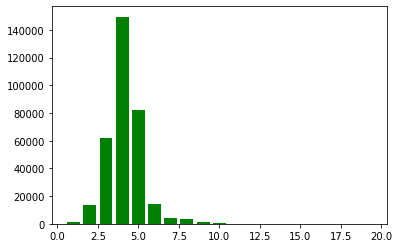

In [4]:
num_repetition = {}
for i in range(159):
    for j in range(2100):
        _shape = neural_data['A'][i][j].shape
        if len(_shape)==1:
            if 1 in num_repetition:
                num_repetition[1] += 1
            else: 
                num_repetition[1] = 1
        else:
            if _shape[1] in num_repetition:
                num_repetition[_shape[1]] += 1
            else: 
                num_repetition[_shape[1]] = 1
plt.bar(num_repetition.keys(), num_repetition.values(), color='g')
plt.show()

(650, 4)


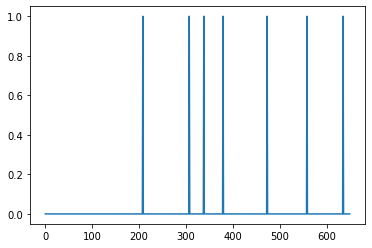

In [5]:
neuron_index = 2 # 159 neurons
img_index = 0 # 2100 images
repetition_index = 0
print(neural_data['A'][neuron_index][img_index].shape)
plt.plot(np.arange(650), neural_data['A'][neuron_index][img_index][:,repetition_index])
plt.show()
# 200ms + 100 + 200
# signal_var: var of the mean response to each stimuli
# noise_var: var of the response of each stimuli, average over all stimuli

In [6]:
# get spiking rate - count 50-350ms after onset 
# which is 200-550
start_ms = 200
end_ms = 500
# start_ms = 0
# end_ms = 650
spiking_rate = []
for neuron_index in range(159):
    neuron_spiking_rate = []
    for img_index in range(2100):
        _shape = neural_data['A'][neuron_index][img_index].shape
        if len(_shape) == 1:
            neuron_spiking_rate.append(np.array(neural_data['A'][neuron_index][img_index][start_ms:end_ms].sum())[..., np.newaxis])
        else:
            neuron_spiking_rate.append(neural_data['A'][neuron_index][img_index][start_ms:end_ms].sum(0))
    spiking_rate.append(neuron_spiking_rate)

In [7]:
spiking_rate[0][3]

array([1., 0., 1., 2., 2.])

In [8]:
# get avg spiking rate
avg_spiking_rate = np.zeros((2100,159))
for img_index in range(2100):
    for neuron_index in range(159): 
        avg_spiking_rate[img_index][neuron_index] = np.mean(spiking_rate[neuron_index][img_index])

In [9]:
# get noise ceiling with all stimuli - not used
noise_ceiling_all_stimuli = np.zeros(159)
for neuron_index in tqdm(range(159)):
    noise_var_list = []
    all_trials_rate = []
    for img_index in range(2100):
        _spiking_rate = spiking_rate[neuron_index][img_index]
        noise_var_list.append(np.var(_spiking_rate))
        all_trials_rate.extend(_spiking_rate)
    signal_var = np.var(all_trials_rate)
    # signal_var = np.var(avg_spiking_rate[:, neuron_index])
    noise_var = np.mean(noise_var_list)
    noise_ceiling = 1 - noise_var/signal_var
    noise_ceiling_all_stimuli[neuron_index] = noise_ceiling

100%|██████████| 159/159 [00:07<00:00, 20.65it/s]


In [ ]:
(noise_ceiling_all_stimuli < 0.1).sum(), noise_ceiling_all_stimuli.min()

# RSA

In [ ]:
# get bio RDM
data = rsatoolbox.data.Dataset(avg_spiking_rate.reshape(2100,-1))
rdms = rsatoolbox.rdm.calc_rdm(data)
rdm_bio = rdms.get_matrices().squeeze()

plt.imshow(rdm_bio)
plt.axis("off")
plt.show()

In [ ]:
# read feats
# resnet50, alexnet, vgg16
# resnet50_layer1, resnet50_layer2, resnet50_layer3, resnet50_layer4_no_pooling
# vgg16_layer1, vgg16_layer2, vgg16_layer3
# resnet50-trained-pretrained-vbsl, resnet50-trained-scratch-vbsl
# rn50_preIN_notexture_sizeVar_best, rn50_preIN_notexture_model_best, rn50_preIN_texture_model_best
model_name = 'vgg16'
preapplied_pca = False
n_components = 50
rand_sampling = False
sampled_dim = 2048

if preapplied_pca:
    filename = f'{model_name}_feats_pca{n_components}.pth'
elif rand_sampling: 
    filename = f'{model_name}_feats_RandSample{sampled_dim}.pth'
else:
    filename = f'{model_name}_feats.pth'
_path = os.path.join("../data/face_data/data_real_face/", filename)
inputs = torch.load(_path)
print(f'read from {_path}')
inputs.shape

In [ ]:
# # optional: apply PCA
# pca = PCA(n_components = n_components)
# inputs = pca.fit_transform(inputs)
# print(inputs.shape)

# optional: apply random sampling
sampled_indexes = np.random.randint(inputs.shape[1], size=2048)
inputs = inputs[:, sampled_indexes]
print(inputs.shape)

In [ ]:
# get model RDM
data = rsatoolbox.data.Dataset(inputs.reshape(2100,-1))
rdms = rsatoolbox.rdm.calc_rdm(data)
rdm_model = rdms.get_matrices().squeeze()

plt.imshow(rdm_model)
plt.axis("off")
plt.show()

In [ ]:
from scipy.stats import pearsonr
_corr, _ = pearsonr(rdm_model.reshape(-1), rdm_bio.reshape(-1))
_corr

In [ ]:
results_list_RandSample2048 = [0.29624945943605313, 0.22335366766229384, 0.41593623215136016, 0.40907623969720486]
model_name_list = ["vgg16_layer1", "vgg16_layer2", "vgg16_layer3", "vgg16_penultimate"]
results = results_list_RandSample2048

for i, v in enumerate(results):
    plt.text(i-0.3, v+0.01, str(v)[:6])
plt.bar(model_name_list, results)
plt.ylim([0.1, 0.55])
plt.xticks(rotation=45)
plt.title("RSA corr model-vs-macaque; PCA50")
plt.show()

In [ ]:
results_list_PCA50 = [0.2428968498899268,  0.1893073461163859, 0.30504798631721713, 0.36368147338687257,
                     0.3970691717537696, 0.4047527056534191, 0.5041516303389645]
results_list_RandSample2048 = [0.34310852239035194, 0.30832995211896486, 0.3356866487064144, 0.35325005261712994,
                              0.40606521438845294, 0.42271192536553454, 0.5221974258205724]
results = results_list_PCA50

model_name_list = ["rn50_layer1", "rn50_layer2", "rn50_layer3", "rn50_layer4_NoPooling",
                  'resnset50', 'vgg16', 'alexnet']

color_list = ['blue'] * 5 + ['green', 'red'] 
for i, v in enumerate(results):
    plt.text(i-0.3, v+0.01, str(v)[:6])
plt.bar(model_name_list, results, color=color_list, alpha=0.7)
plt.ylim([0.1, 0.55])
plt.xticks(rotation=45)
plt.title("RSA corr model-vs-macaque; PCA50")
plt.show()

# regression analysis

In [9]:
# read feats
# resnet50, alexnet, vgg16
# resnet50_layer1, resnet50_layer2, resnet50_layer3, resnet50_layer4_no_pooling
# resnet50-trained-pretrained-vbsl, resnet50-trained-scratch-vbsl
# rn50_preIN_notexture_sizeVar_best, rn50_preIN_notexture_model_best, rn50_preIN_texture_model_best
model_name = 'resnet50_layer4_no_pooling'
preapplied_pca = True
n_components = 50

if preapplied_pca:
    filename = f'{model_name}_feats_pca{n_components}.pth'
else:
    filename = f'{model_name}_feats.pth'
_path = os.path.join(data_path, "../", filename)
inputs = torch.load(_path)
print(f'read from {_path}')

read from ../../data/face_data/data_real_face/stimuli/../resnet50_layer4_no_pooling_feats_pca50.pth


In [10]:
inputs = inputs
outputs = avg_spiking_rate
inputs.shape, outputs.shape

((2100, 50), (2100, 159))

In [11]:
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True)

# iter through splits of cv
all_r2 = np.zeros((159, n_splits))
all_pearsonr = np.zeros((159, n_splits))
all_noise_ceiling = np.zeros((159, n_splits))
all_exp_var = np.zeros((159, n_splits))
for neuron_index in tqdm(range(159)):
    for split_index, (train_index, test_index) in enumerate(cv.split(inputs, outputs)):
        # split data
        X_train = inputs[train_index]
        X_test = inputs[test_index]
        y_train = outputs[train_index][:, neuron_index]
        y_test = outputs[test_index][:, neuron_index]
        # transform inputs using PCA 
        if not preapplied_pca:
            pca = PCA(n_components = n_components)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            explained_variance = pca.explained_variance_ratio_
        # print(f"PCA explained variance with {n_components} components: %.4f" %(explained_variance.sum()))
        # fit model
        # clf = LinearRegression()
        clf = Ridge()
        clf.fit(X_train, y_train)
        r2 = clf.score(X_test, y_test) # coefficient of determination
        y_pred = clf.predict(X_test)
        r_pearson = pearsonr(y_test, y_pred)[0] 
        exp_var = explained_variance_score(y_test, y_pred)
        # get noise ceiling
        noise_var_list = []
        all_trials_rate = []
        for text_img_index in test_index:
            _spiking_rate = spiking_rate[neuron_index][text_img_index]
            noise_var_list.append(np.var(_spiking_rate))
            all_trials_rate.extend(_spiking_rate)
        signal_var = np.var(all_trials_rate)
        noise_var = np.mean(noise_var_list)
        noise_ceiling = 1 - noise_var/signal_var
        # r2_train = clf.score(X_train, y_train) 
        # print("corrected r2 train: %.4f" % (r2_train/noise_ceiling))
        # record
        all_noise_ceiling[neuron_index][split_index] = noise_ceiling
        all_r2[neuron_index][split_index] = r2
        all_pearsonr[neuron_index][split_index] = r_pearson
        all_exp_var[neuron_index][split_index] = exp_var
    _ceiling = all_noise_ceiling[neuron_index].mean()
    # print("noise ceiling: %.4f" % (_ceiling))
    # print("r2 after corr: %.4f" % (all_r2[neuron_index].mean() / _ceiling))
    # print("exp_var after corr: %.4f" % (all_exp_var[neuron_index].mean() / _ceiling))
    # print("pearsonr**2 after corr: %.4f" % (all_pearsonr[neuron_index].mean()**2 / _ceiling))

100%|██████████| 159/159 [00:36<00:00,  4.38it/s]


In [32]:
# read results
import pickle
with open('saved_dict_200-500ms.pkl', 'rb') as f:
    saved_dict = pickle.load(f)

In [33]:
saved_dict[model_name] = {}
saved_dict[model_name]["r2"] = all_r2
saved_dict[model_name]["r_pearson"] = all_pearsonr
saved_dict[model_name]["noise_ceiling"] = all_noise_ceiling
saved_dict[model_name]["exp_var"] = all_exp_var
# saved_dict[model_name]["noise_ceiling_all_stimuli"] = noise_ceiling_all_stimuli
import pickle
# save results
with open('saved_dict_200-550ms.pkl', 'wb') as f:
    pickle.dump(saved_dict, f)

In [15]:
# results 
# resnet50, alexnet, vgg16
# resnet50-trained-pretrained-vbsl, resnet50-trained-scratch-vbsl
# rn50_preIN_notexture_sizeVar_best, rn50_preIN_notexture_model_best, rn50_preIN_texture_model_best
_model_name = model_name
print(_model_name)
print((saved_dict[_model_name]["exp_var"].mean(1) / saved_dict[_model_name]["noise_ceiling"].mean(1)).mean())

resnet50_layer4_no_pooling
0.5241528261563941


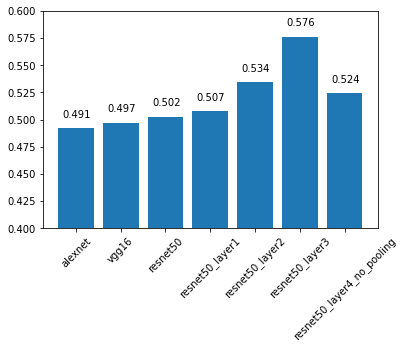

In [28]:
results_list_PreAppliedPCA50 = [0.46777573319269156, 0.47583038046000187, 0.515894645726497, 0.43090077060822723,
                               0.5065832432376453, 0.5348208956039041, 0.5759331604909624, 0.497601097379431]
model_name_list = ["vgg16_layer1", "vgg16_layer2", "vgg16_layer3", "vgg16_penultimate",
                  'resnet50_layer1', 'resnet50_layer2', 'resnet50_layer3', "resnet50_penultimate"]
results = results_list_PreAppliedPCA50

for i, v in enumerate(results):
    plt.text(i-0.3, v+0.01, str(v)[:6])
plt.bar(model_name_list, results)
plt.ylim([0.4, 0.6])
plt.xticks(rotation=45)
plt.ylabel("Explained Variance")
plt.title("Explaining neural data with model features (PCA50)")
plt.show()

In [ ]:
exp_var_norm_list = []
model_name_list = ['alexnet', 'vgg16', 'resnet50', 
                   'resnet50_layer1', 'resnet50_layer2', 'resnet50_layer3', 'resnet50_layer4_no_pooling']
for _model_name in model_name_list:
    _exp_var_norm = (saved_dict[_model_name]["exp_var"].mean(1) / saved_dict[_model_name]["noise_ceiling"].mean(1)).mean()
    exp_var_norm_list.append(_exp_var_norm)
    
for i, v in enumerate(exp_var_norm_list):
    plt.text(i-0.3, v+0.01, str(v)[:5])
plt.bar(model_name_list, exp_var_norm_list)
plt.ylim([0.4, 0.6])
plt.xticks(rotation=45)
plt.show()

In [50]:
saved_dict['resnet50']["noise_ceiling"].mean(1) < 0.1

KeyError: 'resnet50'

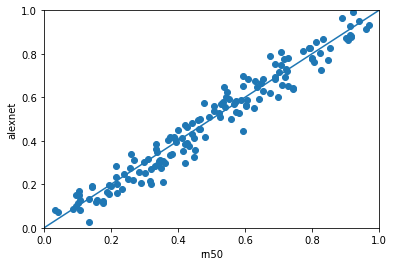

In [71]:
# rn50_preIN_notexture_sizeVar_best, rn50_preIN_notexture_model_best, rn50_preIN_texture_model_best

model_name = 'resnet50'
x = saved_dict[model_name]["exp_var"].mean(1) / saved_dict[model_name]["noise_ceiling"].mean(1)
model_name = 'alexnet'
y = saved_dict[model_name]["exp_var"].mean(1) / saved_dict[model_name]["noise_ceiling"].mean(1)

plt.scatter(x, y)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.xlabel("rn50")
plt.ylabel("alexnet")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [65]:
saved_dict[model_name]["exp_var"].shape

(159, 50)